In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
# reflect the tables
Base.prepare(engine, reflect=True)


/var/folders/kc/r9q5_v3x3vx9sh_1q1hvz_380000gn/T/ipykernel_6718/1272367606.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [63]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

In [21]:
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(f"The most recent date in the data set is: {most_recent_date}")




The most recent date in the data set is: 2017-08-23


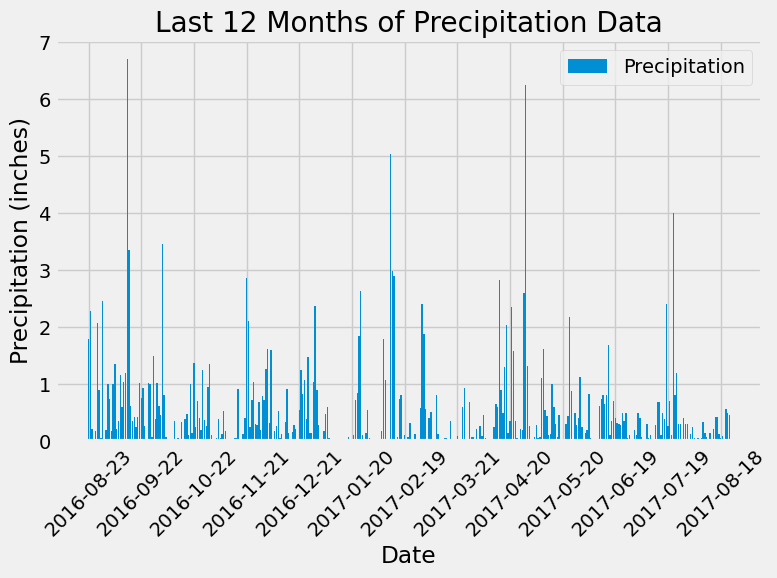

In [64]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the most recent date
one_year_ago = (pd.to_datetime(most_recent_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')

# Query precipitation data for the last 12 months
precipitation_data = (session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).order_by(Measurement.date).all())

# Convert the results to a DataFrame for easier plotting
precipitation_data_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Plot the results
plt.figure(figsize=(8, 6))
plt.bar(precipitation_data_df["Date"], precipitation_data_df["Precipitation"], label="Precipitation")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Last 12 Months of Precipitation Data")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(30)) 
plt.legend()
plt.tight_layout()
plt.show()



In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_data_df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [32]:
# Design a query to calculate the total number of stations in the dataset
number_of_station= session.query(func.count(Station.station)).scalar()
number_of_station

9

In [37]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
most_active_stations




[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0]

temp_stats_from_MAID = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station_id).all()
lowest_temp, highest_temp, avg_temp = temp_stats_from_MAID[0]
temp_stats_from_MAID

[(54.0, 85.0, 71.66378066378067)]

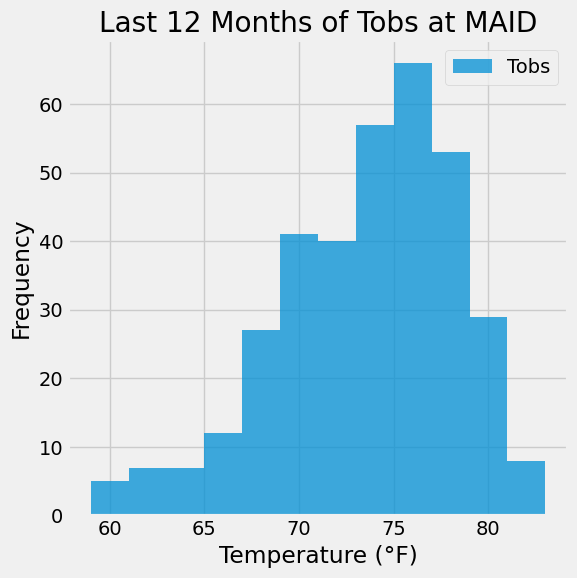

In [55]:
tobs_last12months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year_ago).filter(Measurement.station == most_active_station_id).order_by(Measurement.date).all()
tobs_last12months

tobs_last12months_df = pd.DataFrame(tobs_last12months, columns=["Date", "Temperature"])

plt.figure(figsize=(6, 6))
plt.hist(tobs_last12months_df["Temperature"], bins=12, label="Tobs", alpha=0.75)
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.title("Last 12 Months of Tobs at MAID")
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()